# Training the Best Random Forest Classifier:

In [1]:
import pandas as pd
import numpy as np

import missingno as msno
import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from verstack.stratified_continuous_split import scsplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

## Load the Data:

In [2]:
very_light_data            = pd.read_csv("Data/inverted_OCR.csv")
very_light_data            = very_light_data.drop(columns = ['Index'])

very_light_data_withoutMIX = pd.read_csv("Data/inverted_OCR_without_MIX.csv")
very_light_data_withoutMIX = very_light_data_withoutMIX.drop(columns = ['Index'])

## Train a baseline model

In [3]:
X_train, X_test, y_train, y_test = scsplit(very_light_data_withoutMIX.drop(columns="type"), very_light_data_withoutMIX['type'],
                                           stratify=very_light_data_withoutMIX['type'],
                                           train_size=0.8, test_size=0.2,
                                            continuous = False) # tested

In [57]:


param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [3, 8],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [300, 500]
}

forest_reg = RandomForestClassifier(random_state=42, class_weight="balanced")
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_grid,
                                n_iter=5, cv=5, scoring='f1_weighted', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=5,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 100],
                                        'max_features': [3, 8],
                                        'min_samples_leaf': [3, 5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [300, 500]},
                   random_state=42, scoring='f1_weighted')

Runs in around 10 min

In [58]:

cvres = rnd_search.cv_results_
for f1_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f1_score, params)

0.9952143349587228 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 100, 'bootstrap': True}
0.9952143349587228 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 50, 'bootstrap': True}
0.9957661752405151 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 100, 'bootstrap': True}
0.9939955888129829 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 100, 'bootstrap': True}
0.9957661752405151 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 50, 'bootstrap': True}


In [59]:
final_model = rnd_search.best_estimator_

#### We save the best model:

In [69]:
pickle.dump(final_model, open("models/best_2class_estimator.pkl", "wb"))

#### We can load the previously trained model:

In [64]:
load_model   = True
loaded_model = None
if(load_model):
    loaded_model = pickle.load(open("models/best_2class_estimator.pkl", "rb"))
    loaded_model

RandomForestClassifier(class_weight='balanced', max_depth=100, max_features=8,
                       min_samples_leaf=3, n_estimators=300, random_state=42)

#### We then evaluate the best model:

In [68]:
if(loaded_model):final_model=loaded_model

scores = cross_val_score(final_model, X_train, y_train,
                         scoring="f1_weighted", cv=5)

In [69]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

print("Validation Dataset")
display_scores(scores)

Validation Dataset
Scores: [0.99516873 0.99401915 0.99631858 0.99608786 0.99689288]
Mean: 0.9956974389412491
Standard Deviation: 0.001006332108869886


In [72]:
predictions = final_model.predict(X_test)
print("Test Dataset")
print(classification_report(y_test, predictions))

Test Dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4470
           1       1.00      1.00      1.00      6390

    accuracy                           1.00     10860
   macro avg       1.00      1.00      1.00     10860
weighted avg       1.00      1.00      1.00     10860



Normalized confusion matrix
[[0.998434   0.001566  ]
 [0.00594679 0.99405321]]


<Figure size 432x432 with 0 Axes>

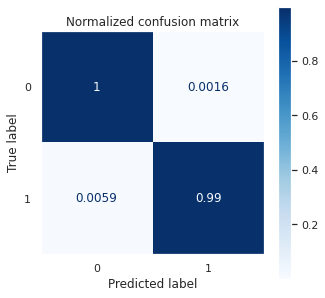

In [63]:
# Plot normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(6,6))
disp = plot_confusion_matrix(final_model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize="true")
disp.ax_.set_title("Normalized confusion matrix")

print("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

## Feature importance

Feature ranking:
1. feature 1 (0.294852)
2. feature 9 (0.193837)
3. feature 17 (0.184682)
4. feature 12 (0.117805)
5. feature 7 (0.060597)
6. feature 8 (0.044017)
7. feature 10 (0.025914)
8. feature 11 (0.022778)
9. feature 3 (0.011007)
10. feature 2 (0.008791)
11. feature 6 (0.008699)
12. feature 5 (0.007866)
13. feature 0 (0.005630)
14. feature 4 (0.003941)
15. feature 16 (0.003932)
16. feature 14 (0.002562)
17. feature 15 (0.002424)
18. feature 13 (0.000666)


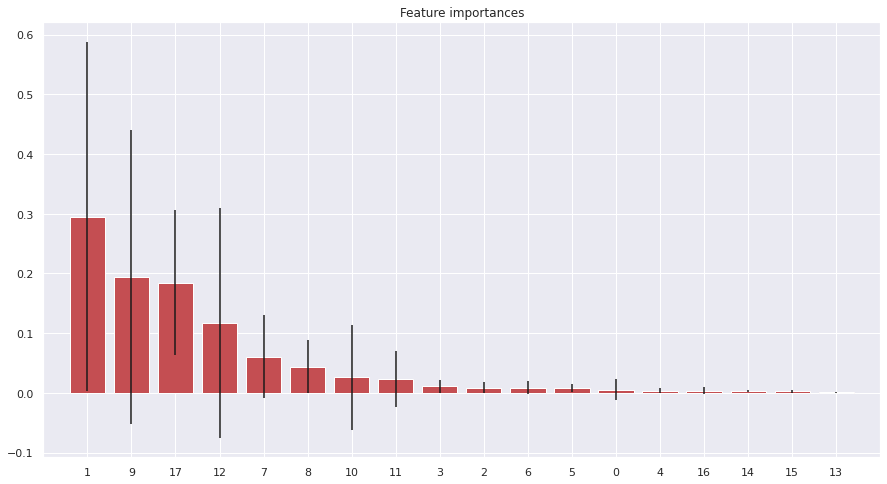

In [64]:
importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


### With MIX:

In [4]:
X_train2, X_test2, y_train2, y_test2 = scsplit(very_light_data.drop(columns="type"), very_light_data['type'],
                                           stratify=very_light_data['type'],
                                           train_size=0.8, test_size=0.2,
                                            continuous = False) # tested

In [8]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [3, 8],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [300, 500]
}

forest_reg = RandomForestClassifier(random_state=42, class_weight="balanced")
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_grid,
                                n_iter=5, cv=5, scoring='f1_weighted', random_state=42)
rnd_search.fit(X_train2, y_train2)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=5,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 100],
                                        'max_features': [3, 8],
                                        'min_samples_leaf': [3, 5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [300, 500]},
                   random_state=42, scoring='f1_weighted')

In [9]:

cvres = rnd_search.cv_results_
for f1_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f1_score, params)

0.9868622605740116 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 100, 'bootstrap': True}
0.9868622605740116 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 50, 'bootstrap': True}
0.9879999543022786 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 100, 'bootstrap': True}
0.9852139107217107 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 100, 'bootstrap': True}
0.9879999543022786 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 50, 'bootstrap': True}


In [10]:
final_model2 = rnd_search.best_estimator_

In [11]:
pickle.dump(final_model2, open("models/best_3class_estimator.pkl", "wb"))

### Load the model and test its performance:

In [5]:
final_model2 = pickle.load(open("models/best_3class_estimator.pkl", "rb"))

In [13]:
predictions2 = final_model2.predict(X_test2)
print("Test Dataset")
print(classification_report(y_test2, predictions2))

Test Dataset
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99     10297
           0       0.97      0.99      0.98      4470
           1       1.00      0.98      0.99      6390

    accuracy                           0.99     21157
   macro avg       0.99      0.99      0.99     21157
weighted avg       0.99      0.99      0.99     21157



Normalized confusion matrix
[[0.98805477 0.00980868 0.00213654]
 [0.00425056 0.99440716 0.00134228]
 [0.01048513 0.00453834 0.98497653]]


<Figure size 720x720 with 0 Axes>

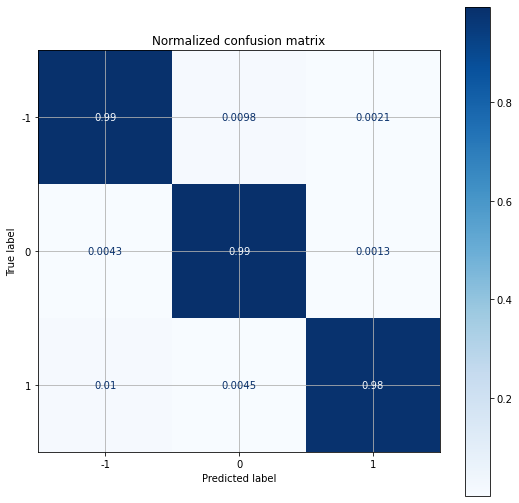

In [14]:
# Plot normalized confusion matrix
class_names = [-1, 0,1]
plt.figure(figsize=(10,10))
disp = plot_confusion_matrix(final_model2, X_test2, y_test2,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize="true")
disp.ax_.set_title("Normalized confusion matrix")

print("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(9,9)
plt.show()

## Feature importance

Feature ranking:
1. feature 9 (0.248376)
2. feature 17 (0.195895)
3. feature 12 (0.093240)
4. feature 2 (0.086339)
5. feature 1 (0.072154)
6. feature 7 (0.056727)
7. feature 8 (0.056608)
8. feature 10 (0.040398)
9. feature 11 (0.030092)
10. feature 0 (0.029303)
11. feature 3 (0.015012)
12. feature 6 (0.014658)
13. feature 14 (0.013739)
14. feature 4 (0.013181)
15. feature 5 (0.012537)
16. feature 16 (0.010445)
17. feature 15 (0.005714)
18. feature 13 (0.005582)


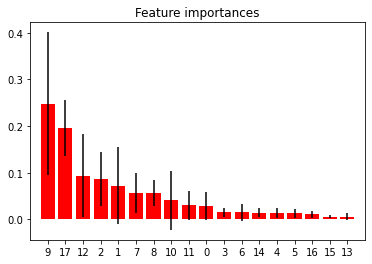

In [15]:
importances = final_model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train2.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train2.shape[1]), indices)
plt.xlim([-1, X_train2.shape[1]])
plt.show()


### With seperated traders:

In [6]:
X_train3, X_test3, y_train3, y_test3 = pd.read_pickle("Processed_data/X_train_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/X_test_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/y_train_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/y_test_evenly_splitted_traders.pkl")

In [7]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [3, 8],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [300, 500]
}

forest_reg = RandomForestClassifier(random_state=42, class_weight="balanced")
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_grid,
                                n_iter=5, cv=5, scoring='f1_weighted', random_state=42)
rnd_search.fit(X_train3, y_train3)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=5,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 100],
                                        'max_features': [3, 8],
                                        'min_samples_leaf': [3, 5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [300, 500]},
                   random_state=42, scoring='f1_weighted')

In [8]:

cvres = rnd_search.cv_results_
for f1_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f1_score, params)

0.8492911875026972 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 100, 'bootstrap': True}
0.8492911875026972 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 50, 'bootstrap': True}
0.85046490632888 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 100, 'bootstrap': True}
0.8465482170352207 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 100, 'bootstrap': True}
0.85046490632888 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 50, 'bootstrap': True}


In [9]:
final_model3 = rnd_search.best_estimator_

In [10]:
pickle.dump(final_model3, open("models/best_3class_estimator_seperated_traders.pkl", "wb"))

### Load the model and test its performance:

In [5]:
final_model3 = pickle.load(open("models/best_3class_estimator_seperated_traders.pkl", "rb"))

In [11]:
predictions3 = final_model3.predict(X_test3)
print("Test Dataset")
print(classification_report(y_test3, predictions3))

Test Dataset
              precision    recall  f1-score   support

          -1       0.67      0.68      0.67     10870
           0       0.82      0.96      0.88      5636
           1       0.54      0.43      0.48      6136

    accuracy                           0.68     22642
   macro avg       0.67      0.69      0.68     22642
weighted avg       0.67      0.68      0.67     22642



Normalized confusion matrix
[[6.80864765e-01 1.08003680e-01 2.11131555e-01]
 [4.32931157e-02 9.55464869e-01 1.24201561e-03]
 [5.64863103e-01 1.62972621e-04 4.34973924e-01]]


<Figure size 720x720 with 0 Axes>

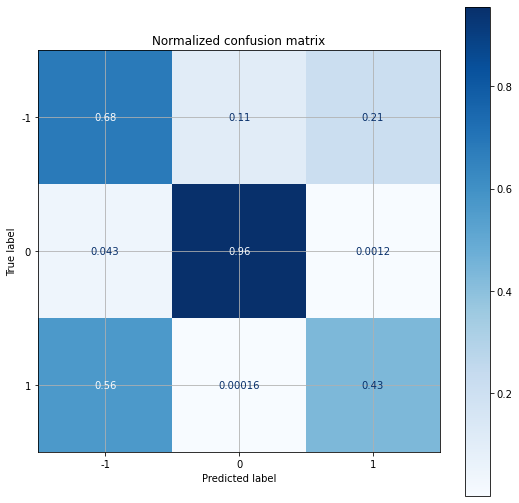

In [12]:
# Plot normalized confusion matrix
class_names = [-1, 0,1]
plt.figure(figsize=(10,10))
disp = plot_confusion_matrix(final_model3, X_test3, y_test3,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize="true")
disp.ax_.set_title("Normalized confusion matrix")

print("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(9,9)
plt.show()

## Feature importance

Feature ranking:
1. feature 9 (0.230911)
2. feature 17 (0.187995)
3. feature 12 (0.109001)
4. feature 2 (0.106987)
5. feature 7 (0.059549)
6. feature 10 (0.056457)
7. feature 1 (0.055629)
8. feature 8 (0.038051)
9. feature 11 (0.035148)
10. feature 6 (0.029722)
11. feature 0 (0.019759)
12. feature 3 (0.017371)
13. feature 5 (0.014852)
14. feature 4 (0.013395)
15. feature 16 (0.011654)
16. feature 14 (0.006183)
17. feature 15 (0.004494)
18. feature 13 (0.002844)


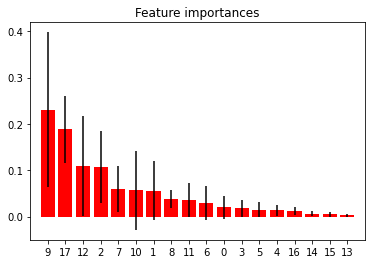

In [13]:
importances = final_model3.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model3.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train3.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train3.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train3.shape[1]), indices)
plt.xlim([-1, X_train3.shape[1]])
plt.show()
